In [1]:
# import keras
# import keras.backend as K
# from keras.datasets import mnist
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from urllib.parse import urlparse
# from skimage.io import imread
from PIL import Image, ImageEnhance
# from PIL import ImageFilter
# from skimage.transform import resize
import image_utils as iu
# from keras.datasets import mnist
from keras.models import Sequential
# from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization
from keras.layers import *
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.resnet50 import ResNet50
from keras import Input, Model
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy_utils as nu
# from osgeo import gdal
# from osgeo import gdal_array
# from osgeo import osr
# import geotiff_utils as gu


In [2]:
data_path = 'E:\\Staff\\Asare\\Ssm\\data'
segmentation_path = os.path.join(data_path, 'segmentation')

# mining_path = os.path.join(segmentation_path, 'mining')
# training data paths
training_path = os.path.join(segmentation_path, 'training')
#train
train_path = os.path.join(training_path, 'train')
train_real_path = os.path.join(train_path, 'real')
train_mask_path = os.path.join(train_path, 'mask')
#val
val_path = os.path.join(training_path, 'val')
val_real_path = os.path.join(val_path, 'real')
val_mask_path = os.path.join(val_path, 'mask')
#test
test_path = os.path.join(training_path, 'test')
test_real_path = os.path.join(test_path, 'real')
test_mask_path = os.path.join(test_path, 'mask')
# Saved models
saved_model_path = os.path.join(segmentation_path, 'saved-models')
# Checkpoint path
checkpoint_path = os.path.join(segmentation_path, 'train_ckpt')
# checkpoint_file_path = os.path.join(checkpoint_path, "binary_class_segmentation.ckpt")
# Predictions path.
prediction_path = os.path.join(segmentation_path, 'predictions')
# Predicted image path.


In [3]:
# import os
# import rasterio
# import numpy as np
from tensorflow.keras.utils import Sequence
import ntpath


class DataGenerator(Sequence):
    def __init__(self, image_dir, size,batch_size=32, shuffle=True, real_data_preprocessing_function=None, mask_data_preprocessing_function=None):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        # self.shape = shape
        self.size = size #(128, 128)
        self.real_data_preprocessing_function = real_data_preprocessing_function
        self.mask_data_preprocessing_function = mask_data_preprocessing_function
        self.image_list, self.mask_list = self.__load_filenames()
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_list) // self.batch_size

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_list_temp = [self.image_list[k] for k in indexes]
        mask_list_temp = [self.mask_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_list_temp, mask_list_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_filenames(self):
        # image_list = []
        mask_list = []
        image_list = iu.get_all_files(
            os.path.join(self.image_dir, 'real'), '*.npz', True)
        for real_image_path in image_list:
            mask_path = os.path.join(self.image_dir, 'mask', ntpath.basename(
                real_image_path).replace('.npz', '.png'))
            if not os.path.isfile(mask_path):
               raise Exception("Cannot find mask for " + real_image_path)
            mask_list.append(mask_path)
        print(
            f"Found {len(image_list)} image pair.")
        return image_list, mask_list

    def __data_generation(self, image_list_temp, mask_list_temp):
        width, height = self.size
        X = np.empty((self.batch_size, height, width, 4))
        # X1 = np.empty((self.batch_size, height, width, 2))
        y = np.empty((self.batch_size, height, width))
        for i, (image_name, mask_name) in enumerate(zip(image_list_temp, mask_list_temp)):
            np_gt = nu.load_numpy_file(image_name)
            np_gt = np.asarray(np_gt, dtype='uint16')
            mask_image = iu.read_image(mask_name, 'L')
            if np_gt.shape != (height, width):
                np_gt = nu.resize_np_image(np_gt, self.size)
            if mask_image.size != self.size:
                mask_image = mask_image.resize(self.size, resample=Image.BOX)
            np_mask_image = np.asarray(mask_image, dtype='uint8')
            if self.real_data_preprocessing_function != None:
                np_gt = self.real_data_preprocessing_function(np_gt)
                # print(np_gt)
            if self.mask_data_preprocessing_function != None:
                np_mask_image = self.mask_data_preprocessing_function(np_mask_image)
            X[i, ] = np_gt
            # X1[i, ] = np_gt[:, :, -2:] / 10000000
            y[i, ] = np_mask_image #.flatten()       
        return X, y


In [4]:
# def contains_nan(arr):
#     return np.isnan(arr).any()

# def set_values_to_1(arr):
#     # Create a copy of the input array
#     result = np.copy(arr)
    
#     # Set all values greater than 0 to 1
#     result[result > 0] = 1
    
#     return result

#Converts the image into a numpy array and normalizes the pixel values.
def real_image_preprocessing_func(np_gt):
    return np_gt / 6000

#Converts the mask into a numpy array and normalizes the pixel values.
#Values are also rounded to create a sharp image.
# def mask_preprocessing_func(np_mask):
#     # np_mask = np_mask / 255
#     np_mask = np.round(np_mask)
#     np_mask = set_values_to_1(np_mask)
#     return np_mask


In [5]:
# load and iterate training dataset
image_width = 512
image_height = 512
batch_size = 8
image_size = (image_width, image_height)
train_datagen = DataGenerator(train_path, (image_width, image_height),batch_size, True,
                              real_data_preprocessing_function=real_image_preprocessing_func)
val_datagen = DataGenerator(val_path, (image_width, image_height), batch_size, True,
                            real_data_preprocessing_function=real_image_preprocessing_func)
test_datagen = DataGenerator(test_path, (image_width, image_height),batch_size, True,
                             real_data_preprocessing_function=real_image_preprocessing_func)

# train_datagen = DataGenerator(train_path, (image_width, image_height), batch_size, False,
#                               real_data_preprocessing_function=real_image_preprocessing_func, mask_data_preprocessing_function=mask_preprocessing_func)
# val_datagen = DataGenerator(val_path, (image_width, image_height), batch_size, False,
#                             real_data_preprocessing_function=real_image_preprocessing_func, mask_data_preprocessing_function=mask_preprocessing_func)
# test_datagen = DataGenerator(test_path, (image_width, image_height), batch_size, False,
#                              real_data_preprocessing_function=real_image_preprocessing_func, mask_data_preprocessing_function=mask_preprocessing_func)


Found 276971 image pair.
Found 30774 image pair.
Found 0 image pair.


In [6]:
# A folder for saving checkpoint is created for
iu.create_dir_if_not_exists(checkpoint_path)

def create_checkpoint():
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    verbose=0,
    save_weights_only=True,
    save_freq=10)
    return cp_callback

cp_callback = create_checkpoint()


## Modelling
Image segmentation is achieved with the U-net architecture.<br>

In [7]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    # conv = Conv2D(n_filters,
    #               3,   # Kernel size
    #               activation='relu',
    #               padding='same',
    #               kernel_initializer='HeNormal')(conv)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # att1 = Conv2D(n_filters, 1, activation='sigmoid')(
    #     conv)  # Attention mechanism
    # conv = Multiply()([conv, att1])  # Element-wise multiplication

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input = None, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
        n_filters,
        (3, 3),    # Kernel size
        strides=(2, 2),
        padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    if skip_layer_input is not None:
       merge = concatenate([up, skip_layer_input], axis=3)
    else:
        merge = up
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                  3,     # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    # conv = Conv2D(n_filters,
    #               3,   # Kernel size
    #               activation='relu',
    #               padding='same',
    #               kernel_initializer='HeNormal')(conv)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    return conv


In [175]:
def create_unet():
    input_size = (image_height, image_width, 4)
    n_filters = 32
    n_classes = 4

    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(
       cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(
       cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(
        cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(
       cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=True)
    cblock6 = EncoderMiniBlock(
       cblock5[0], n_filters*16, dropout_prob=0.3, max_pooling=True)
    cblock7 = EncoderMiniBlock(
       cblock6[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock00 = DecoderMiniBlock(cblock7[0], cblock6[1],  n_filters * 16)
    ublock0 = DecoderMiniBlock(ublock00, cblock5[1],  n_filters * 16)
    ublock1 = DecoderMiniBlock(ublock0, cblock4[1],  n_filters * 8)
    ublock2 = DecoderMiniBlock(ublock1, cblock3[1],  n_filters * 4)
    ublock3 = DecoderMiniBlock(ublock2, cblock2[1],  n_filters * 2)
    ublock4 = DecoderMiniBlock(ublock3, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
               3,
               activation='relu',
               padding='same',
               kernel_initializer='he_normal')(ublock4)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    # model1.compile(loss=dice_loss, optimizer='adam', metrics=[
    #               dice_coef, iou])

    # model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
# Mirrored strategy is used to distribute the training data accross all gpu's
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
     cp_callback = create_checkpoint()
     model = create_unet()
     lr = 1e-4
     model.compile(tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [11]:
model.fit(train_datagen, validation_data=val_datagen,
          callbacks=[cp_callback], epochs=10)

34621/34621 [==============================] - 36345s 1s/step - loss: 0.0088 - accuracy: 0.9966 - val_loss: 0.0086 - val_accuracy: 0.9967


In [245]:
def calculate_precision_recall(ground_truth_mask, predicted_mask, num_classes):
    # print(ground_truth_mask.shape, predicted_mask.shape)
    precision = [None] * num_classes  # np.zeros(num_classes)
    recall = [None] * num_classes  # np.zeros(num_classes)
    precision_dict = dict()
    recall_dict = dict()
    for class_id in range(num_classes):
        true_positives = np.sum(
            (ground_truth_mask == class_id) & (predicted_mask == class_id))
        false_positives = np.sum(
            (ground_truth_mask != class_id) & (predicted_mask == class_id))
        false_negatives = np.sum(
            (ground_truth_mask == class_id) & (predicted_mask != class_id))
        p = None
        r = None
        if true_positives + false_positives != 0:
            p = true_positives / (true_positives + false_positives)
        if true_positives + false_negatives != 0:
            r = true_positives / (true_positives + false_negatives)
        precision_dict[class_id] = p
        recall_dict[class_id] = r
    return precision_dict, recall_dict


def calc_f1_score(precision, recall):
    return (2 * precision * recall) / (precision + recall)

def calculate_raw_scores(ground_truth_mask, predicted_mask, num_classes):
    # print(ground_truth_mask.shape, predicted_mask.shape)
    # precision = [None] * num_classes  # np.zeros(num_classes)
    # recall = [None] * num_classes  # np.zeros(num_classes)
    # precision_dict = dict()
    # recall_dict = dict()
    true_positives_dict = dict()
    false_positives_dict = dict()
    false_negatives_dict = dict()
    for class_id in range(num_classes):
        true_positives = np.sum(
            (ground_truth_mask == class_id) & (predicted_mask == class_id))
        false_positives = np.sum(
            (ground_truth_mask != class_id) & (predicted_mask == class_id))
        false_negatives = np.sum(
            (ground_truth_mask == class_id) & (predicted_mask != class_id))
        true_positives_dict[class_id] = true_positives
        false_positives_dict[class_id] = false_positives
        false_negatives_dict[class_id] = false_negatives
    return true_positives_dict, false_positives_dict, false_negatives_dict

def calculate_mean_precision_recall(model, val_datagen, num_classes):
    total_true_positives_dict = dict()
    total_false_positives_dict = dict()
    total_false_negatives_dict = dict()
    precision_scores = np.zeros(num_classes)
    recall_scores = np.zeros(num_classes)
    f1_scores = np.zeros(num_classes)
    # Iterate over the validation data generator
    for images, labels in val_datagen:
        for image, label in zip(images, labels):
            # Predict the labels using the model
            predictions = model.predict(np.array([image]), verbose=False)
            predicted_classes = np.argmax(predictions, axis=3)
            # print(predicted_classes.shape)
            true_positives_dict, false_positives_dict, false_negatives_dict = calculate_raw_scores(
                label, predicted_classes[0], num_classes)
            # print(precision_dict, recall_dict)
            for class_id in range(num_classes):
                ttp = total_true_positives_dict.get(class_id, 0.0)
                tfp = total_false_positives_dict.get(class_id, 0.0)
                tfn = total_false_negatives_dict.get(class_id, 0.0)
                ttp += true_positives_dict[class_id]
                tfp += false_positives_dict[class_id]
                tfn += false_negatives_dict[class_id]
                total_true_positives_dict[class_id] = ttp
                total_false_positives_dict[class_id] = tfp
                total_false_negatives_dict[class_id] = tfn
    # Calculate average IoU scores for each class
    # class_iou_scores /= class_counts
    for class_id in range(num_classes):
        ttp = total_true_positives_dict.get(class_id)
        tfp = total_false_positives_dict.get(class_id)
        tfn = total_false_negatives_dict.get(class_id)
        p = None
        r = None
        if ttp + tfp != 0:
            p = ttp / (ttp + tfp)
        if ttp + tfn != 0:
            r = ttp / (ttp + tfn)
        precision_scores[class_id] = p
        recall_scores[class_id] = r
        f1_scores[class_id] = calc_f1_score(p, r)
    # Create a DataFrame with class labels and corresponding IoU scores
    iou_df = pd.DataFrame(
        {'class_val': range(num_classes), 'precision': precision_scores, 'recall': recall_scores, 'f1 score': f1_scores})
    # print(precision_total_dict)
    return iou_df



In [246]:
# Assuming you have a trained model called 'model' and a validation data generator called 'val_datagen'
iou_scores = calculate_mean_precision_recall(model, val_datagen, 4)
print(iou_scores)

   class_val  precision    recall  f1 score
0          0   0.997751  0.998634  0.998192
1          1   0.943050  0.912385  0.927464
2          2   0.926273  0.910549  0.918344
3          3   0.910953  0.884762  0.897667


In [ ]:
# plot_model(model, show_shapes=True, show_layer_names=True)

In [222]:
#Model is saved as h5 format after training.
from datetime import datetime
iu.create_dir_if_not_exists(saved_model_path)
saved_model_file = os.path.join(saved_model_path, 'multi_class_unet_model_' +
                                str(datetime.now()).replace(':', '-') + '.h5')
model.save(saved_model_file)
print(saved_model_file)

E:\Staff\Asare\Ssm\data\segmentation\saved-models\multi_class_unet_model_2023-09-17 08-15-59.784156.h5


In [74]:
# The color code or legend for each class is defined for visualization
#Define the class mappings
class_encoding = {0: 'No Data',
                  1: 'Active-Mines',
                  2: 'Abandoned-Mines',
                  3: 'Polluted-Rivers'}

r_class_encoding = {v: k for k, v in class_encoding.items()}
# print(reversed_dict)
new_color_encoding = {3: [255, 255, 0], 
                      2: [180, 96, 0], 
                      1: [251, 72, 196],  
                      0: [0, 0, 0]}

In [75]:
#Converts the output of a multi class unet model into a single channel multi class mask.
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

# Predicts the mask of an image.
def predict_mask(unet, np_img, input_size):
    # split image
    image_width, image_height = input_size
    np_img = nu.resize_np_image(np_img, (image_height, image_width))
    np_img = real_image_preprocessing_func(np_img)
    # print(np_img.max())
    pred = unet.predict(np.array([np_img]))
    # print(pred)
    return np.asarray(create_mask(pred))

In [76]:
#Converts a multi class mask into an RGB legend.
def display_legend(np_image, color_encoding):
    flat_gh_im = np_image.reshape(-1, 1)
    #
    new_gh_im = []
    for x in range(flat_gh_im.shape[0]):
        new_gh_im.append(color_encoding.get(flat_gh_im[x][0], [0, 0, 0]))
    #
    new_gh_im = np.array(new_gh_im).reshape(
        np_image.shape[0], np_image.shape[1], 3)
    enc_im = Image.fromarray(np.array(new_gh_im, dtype=np.uint8))
    return enc_im

In [77]:
# stores the path of an image and a mask pair
class DataLabelPair:
    def __init__(self, data_real_path, label_path):
        self.data_real_path = data_real_path
        self.label_path = label_path

In [180]:
#Gets all the validation data
val_images_path = iu.get_all_files(val_real_path, '*.npz')
print('total files:', str(len(val_images_path)))

total files: 30774


In [181]:
images_val = []
for path in val_images_path:
    image = DataLabelPair(os.path.join(val_real_path, path),
                          os.path.join(val_mask_path, path.replace('.npz', '.png')))
    images_val.append(image)

1/1 [==============================] - 0s 204ms/step


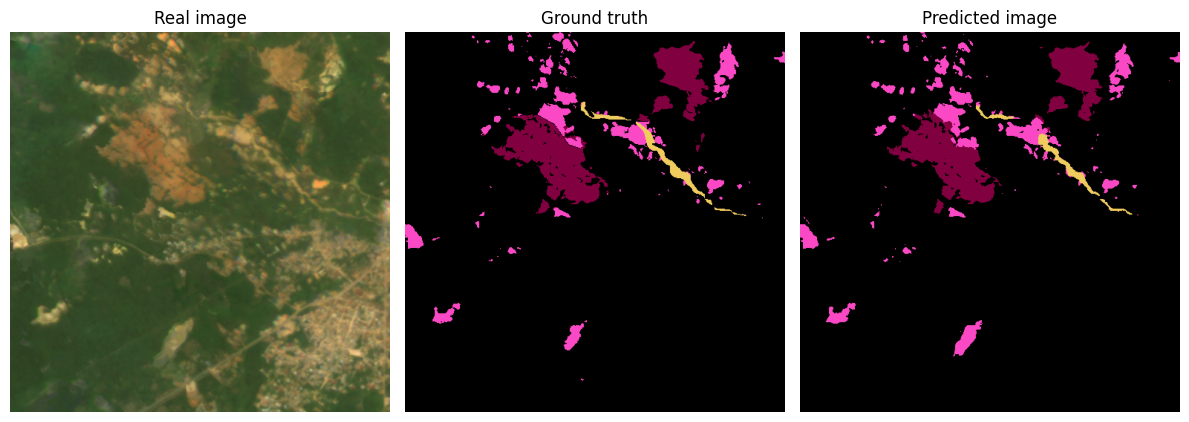

In [243]:
import random
indx =  random.randint(0, len(images_val))
np_gt = nu.load_numpy_file(images_val[indx].data_real_path)
mask_image = iu.read_image(images_val[indx].label_path.replace('.npz', '.png'))
sat_im = gu.display_np_geoTiff(np_gt, (2, 1, 0))
#
np_mask = np.asarray(mask_image)
ground_truth_mask = display_legend(np_mask, new_color_encoding)
#
mask = predict_mask(model, np_gt, (image_width, image_height))
pred_mask = display_legend(mask[0], new_color_encoding)
iu.display_images({'Real image': sat_im, 'Ground truth': ground_truth_mask,
                'Predicted image': pred_mask}, (1, 3))